In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import skopt
import itertools
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold


# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Look at what's inside the data

In [2]:
data = pd.read_csv('data/BlackFriday.csv')
data.dtypes
data.shape
data.head()

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

(537577, 12)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# Visualise basic distributions

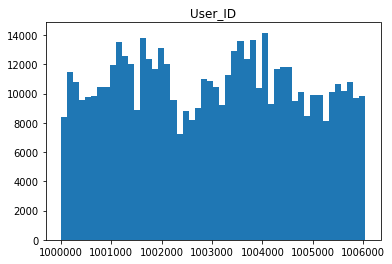

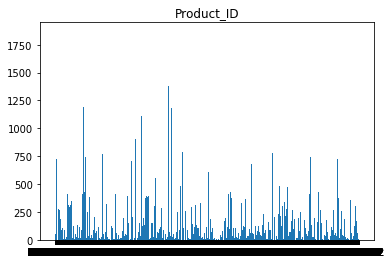

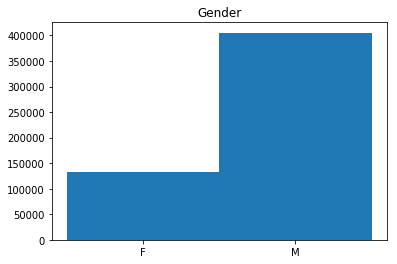

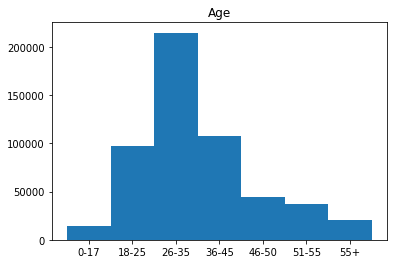

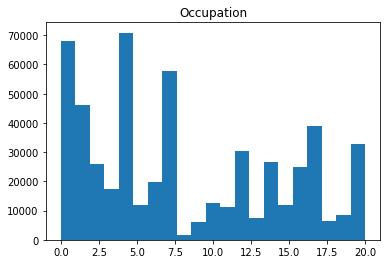

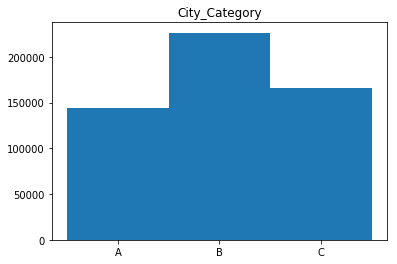

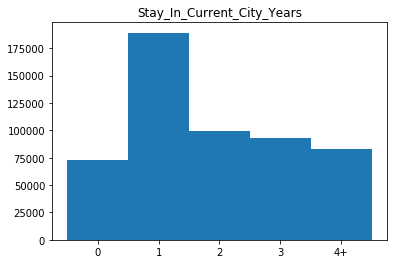

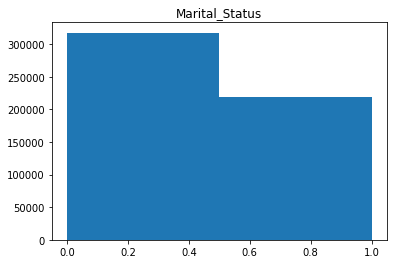

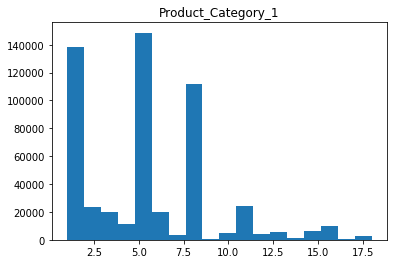

/Users/zgubic/anaconda3/envs/black-friday/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/zgubic/anaconda3/envs/black-friday/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


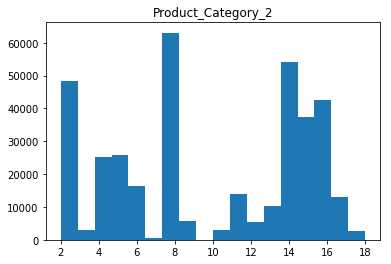

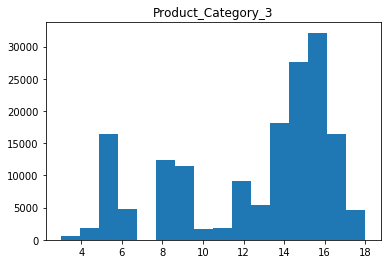

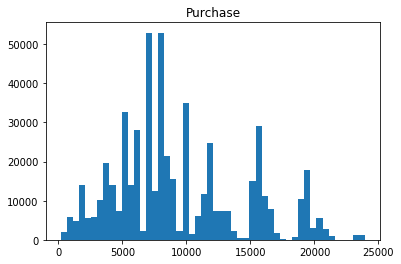

In [3]:
# loop over columns
for col in data.columns.values:

    s = getattr(data, col)
    
    # histogram
    if data.dtypes[col] in ['int64', 'float64']:
        
        # determine the appropriate number of bins
        bins = len(s.unique())
        bins = min(bins, 50)
        
        # plot
        fig, ax = plt.subplots()
        _ = ax.hist(s, bins=bins)
        _ = ax.set_title(col)
        plt.savefig('plots/explore_{}.pdf'.format(col))
        plt.show()
        
    
    # bar plot
    else:
        
        # determine the counts and set indices
        labels, counts = zip(*Counter(s).items())
        indices = np.arange(len(counts))
        
        # and sort them
        counts = [x for _, x in sorted(zip(labels, counts), key=lambda pair: pair[0])]
        labels = sorted(labels)

        # plot
        fig, ax = plt.subplots()
        _ = ax.bar(indices, counts, 1)
        _ = ax.set_xticks(indices)
        _ = ax.set_xticklabels(labels)
        _ = ax.set_title(col)
        plt.savefig('plots/explore_{}.pdf'.format(col))
        plt.show()
    
    

# Do some cleaning

In [4]:
# Product_ID: convert to ints
if data.Product_ID.dtype == object:
    data.Product_ID = data.Product_ID.str.replace('P', '', )
data.Product_ID = data.Product_ID.astype(int)

# Gender: convert to ints
data.rename(columns={'Gender':'Male'}, inplace=True)
data['Male'] = data.replace(['F', 'M'], ['0', '1'])['Male'].astype(int)

# Age: convert to ints (would be better to sample uniform distro in range)
data['Age'] = data.replace(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'], ['15', '22', '30', '40', '48', '53', '60'])['Age'].astype(int)

# stay in the city: to ints
data['Stay_In_Current_City_Years'] = data.replace(['4+'], ['4'])['Stay_In_Current_City_Years'].astype(int)

# City cateogry: to ints
data['City_Category'] = data.replace(['A', 'B', 'C'], ['1', '2', '3'])['City_Category'].astype(int)

# check again
data.dtypes
data.shape
data.head(10)

User_ID                         int64
Product_ID                      int64
Male                            int64
Age                             int64
Occupation                      int64
City_Category                   int64
Stay_In_Current_City_Years      int64
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

(537577, 12)

,User_ID,Product_ID,Male,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,15,10,1,2,0,3,NaN,NaN,8370
1,1000001,248942,0,15,10,1,2,0,1,6.0,14.0,15200
2,1000001,87842,0,15,10,1,2,0,12,NaN,NaN,1422
3,1000001,85442,0,15,10,1,2,0,12,14.0,NaN,1057
4,1000002,285442,1,60,16,3,4,0,8,NaN,NaN,7969
5,1000003,193542,1,30,15,1,3,0,1,2.0,NaN,15227
6,1000004,184942,1,48,7,2,2,1,1,8.0,17.0,19215
7,1000004,346142,1,48,7,2,2,1,1,15.0,NaN,15854
8,1000004,97242,1,48,7,2,2,1,1,16.0,NaN,15686
9,1000005,274942,1,30,20,1,1,1,8,NaN,NaN,7871


# Look at products

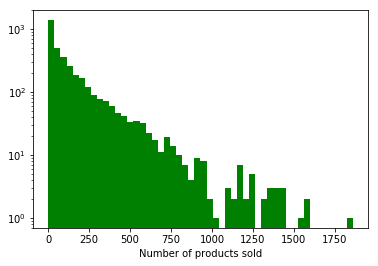

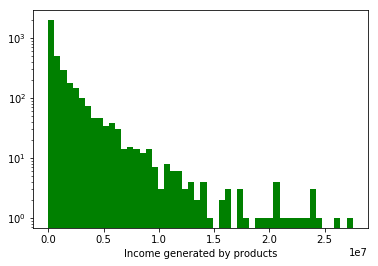

Top 10 products, based on how many times they were sold


Product_ID
265242    1858
110742    1591
25442     1586
112142    1539
57642     1430
184942    1424
46742     1417
58042     1396
59442     1384
145042    1384
dtype: int64

Top 10 products, based on how much income they generated


Product_ID
25442     27532426
110742    26382569
255842    24652442
184942    24060871
59442     23948299
112142    23882624
110942    23232538
237542    23096487
57642     22493690
10742     21865042
Name: Purchase, dtype: int64

In [5]:
# count the number of times the products were sold and how much income they generated
items = data.groupby(data.Product_ID)
n_sold = items.size()
tot_purch = items.sum()['Purchase']

n_sold = n_sold.sort_values(ascending=False)
tot_purch = tot_purch.sort_values(ascending=False)

for metric, name in zip([n_sold, tot_purch], ['Number of products sold', 'Income generated by products']):
    fig, ax = plt.subplots()
    _ = ax.hist(metric, bins=50, color='green')
    ax.set_yscale('log')
    _ = ax.set_xlabel(name)
    plt.savefig('plots/products_{}.pdf'.format(name.replace(' ', '')))
    plt.show()
    
# examine the top performers in both
print('Top 10 products, based on how many times they were sold')
n_sold.head(10)
print('Top 10 products, based on how much income they generated')
tot_purch.head(10)


# Which customers spend the most money?

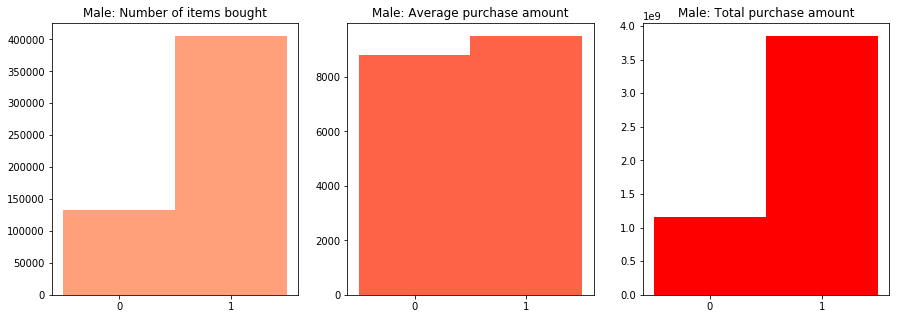

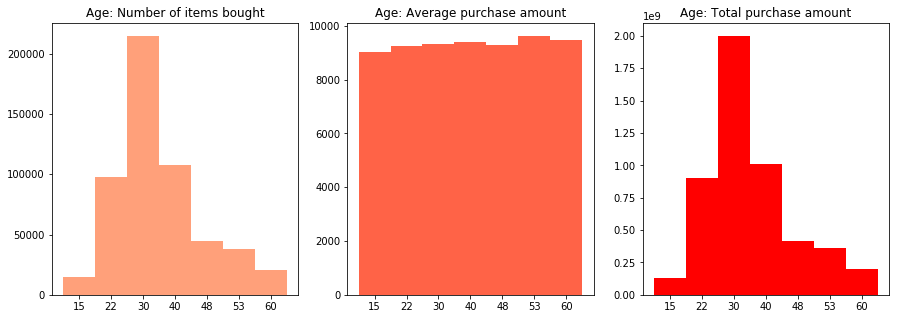

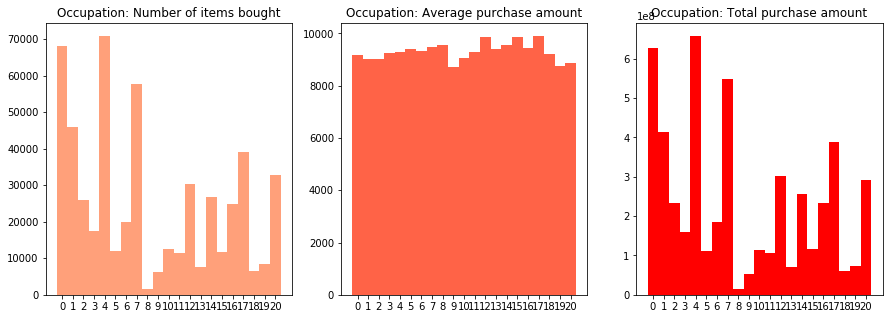

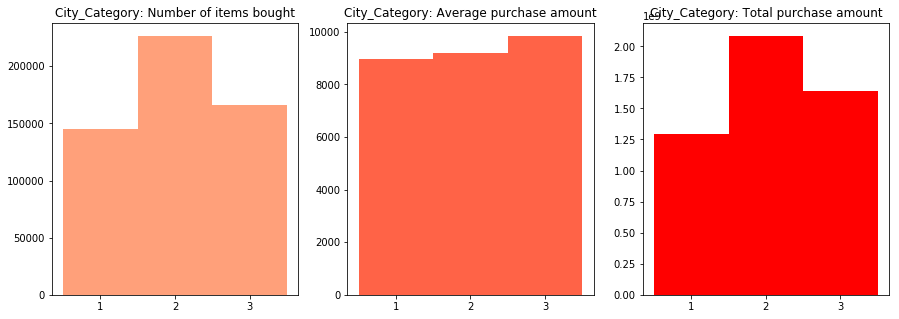

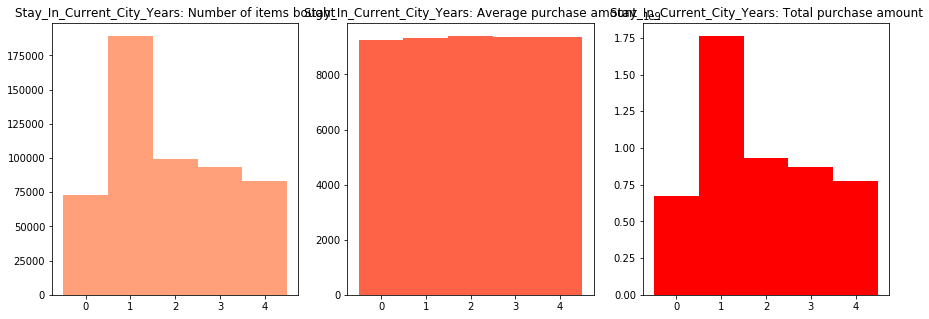

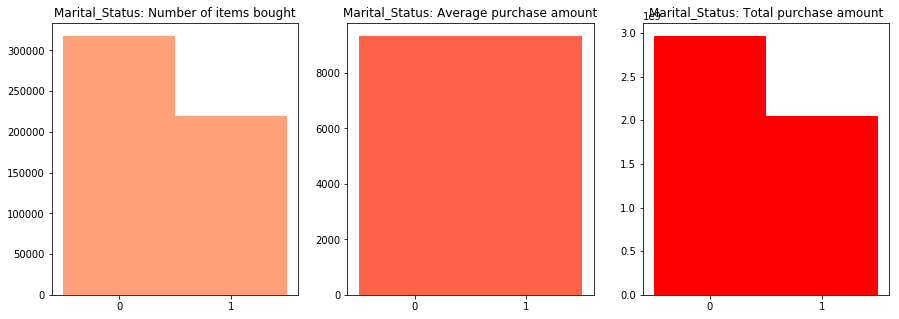

In [6]:
demographics = ['Male', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
properties = ['Purchase']

# loop over demographic properties
for demo in demographics:
    
    # determine the number of items bought and total purchase amounts for each demographic
    demo_series = getattr(data, demo)
    items = data.groupby(demo_series)
    n_bought = items.size() # number of purchases
    mean_purch = items.mean()['Purchase'] # mean purchase
    tot_purch = items.sum()['Purchase'] # total purchase
    demo_groups = n_bought.index.values
    
    # bar chart for each group
    indices = np.arange(len(n_bought))
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
    heights = [n_bought, mean_purch, tot_purch]
    descriptions = ['Number of items bought', 'Average purchase amount', 'Total purchase amount']
    colours = ['lightsalmon', 'tomato', 'r']
    for i, height, desc, c in zip([0,1,2], heights, descriptions, colours):
        _ = ax[i].bar(indices, height, width=1, color=c)
        _ = ax[i].set_xticks(indices)
        _ = ax[i].set_xticklabels(demo_groups)
        _ = ax[i].set_title('{}: {}'.format(demo, desc))
    plt.savefig('plots/customers_{}.pdf'.format(demo))
    plt.show()
    

# Very simple recommender system
   
simply look at how often items are bought together

In [ ]:
# make the network
products = sorted(data.Product_ID.unique())
n_uniq = len(products)
network = pd.DataFrame(np.zeros(shape=(n_uniq, n_uniq)))
network.columns = products
network.index = products
network.head()

# examine users
users = data.User_ID.unique()
n_users = len(users)
print()
print('Number of different user IDs: {}'.format(len(users)))
print('Means the average number of products a person buys is: {}'.format(data.shape[0]/float(len(users))))
print('--> The data is probably from multiple (many?) years')
print('--> This will make the recommender less precise as items from different years may not be related to each other.')
print()

# and fill it in, looping over customers (this takes a while as some customers bought many things, combinations explode)
t0 = time.time()
for i, user in enumerate(users):

    if i%(int(n_users/30.)) == 0:
        t = time.time()
        dt = (t-t0)/(i+1)
        print('{}/{} ({}%), time left: {:2.2f}'.format(i, n_users, int(100.*(i+1)/n_users), dt*(n_users-i)))
    
    products = sorted(data[data.User_ID == user]['Product_ID'])
    
    # record their relations
    for pair in itertools.combinations(products, 2):
        network.at[pair[0], pair[1]] += 1

# transpose it
network = network + network.transpose()

# normalise
product_bought = data.groupby('Product_ID').size()
avg = product_bought.mean()

n_prods = len(product_bought)

for pi, pj in itertools.product(network.index, repeat=2):
    
    tot_i = product_bought.loc[pi]
    tot_j = product_bought.loc[pj]
    network.at[pi, pj] *= avg**2/(tot_i * tot_j)

# and save it
network.to_csv('data/network.csv')
    

In [ ]:

def read_network():
    
    # read
    network = pd.read_csv('data/network.csv')
    
    # turn the extra column to the index
    index = network['Unnamed: 0']
    network.drop(columns=['Unnamed: 0'], inplace=True)
    
    # change type
    network.index = index.values.astype(int)
    network.columns = network.columns.astype(int)
    
    return network

In [ ]:
network = read_network()

network.head()

# recommendation function
def recommend(how_many, product_id, network):
    
    sorted_edges = network[product_id].sort_values(ascending=False)
    best_n = list(sorted_edges.index.values[:how_many])
    return best_n

recommend(10, 142, network)

# Use ML to predict the purchase amount for each row

A bit confused at this point about what the data means:

* User_IDs come in bunches of a few items and repeat several times, suggesting the data is from multiple years.
    * Potentially they could mean the same demographic, but this is unlikely:
        * it doesn't make sense form the company p.o.w. to do this
        * there are not enough User_IDs for the amount of different combinations of demographics
* Not sure what Purchase amounts represent:
    * they are different for the same item
    * they do not come in integer steps (buying 1 or 2 or 3 of the same item) but rather in a continuous fashion
    * it doesn't seem likely that the items would cost different in different stores, as there are too many different values for the same item
    
    
In any case I'll just predict the Purchase column, just to show I can do some ML. In the real world of course it would be nice to clear these things up first of course.

In [46]:

# feature engineering: add average purchase amount for product and product category

# split the data
data_train, data_test = train_test_split(data, test_size=0.25)

# make feature and target frames 
features = list(data.columns.values)
for col in ['Purchase', 'Product_Category_2', 'Product_Category_3']: #(remove nans and infs, too lazy to clean)
    features.remove(col)
target = ['Purchase']

x_train = np.array(data_train[features])
y_train = np.array(data_train[target]).ravel()
x_test = np.array(data_test[features])
y_test = np.array(data_test[target]).ravel()

# define a scoring function
def test_one(model, test):
    
    # unpack
    x_test, y_test = test
    
    y_pred = model.predict(x_test)
    #rms = np.sqrt(np.sum((y_pred - y_test)**2))
    aad = np.mean(np.abs(y_pred - y_test))
    
    return aad


def train_one(hps, train):
    
    # unpack
    x_train, y_train = train
    
    # train
    gbr = GradientBoostingRegressor(**hps)
    gbr.fit(x_train, y_train)
    
    return gbr


def score_one_fold(hps, train, test):
    """
    Score one fold.
    """

    # train
    gbr = train_one(hps, train)
    
    # test
    score = test_one(gbr, test)
    
    return score


# define the k-folded scoring function
def score_kfolds(hps, x, y):
    """
    Do k-folding.
    """
    
    print(hps)
    
    # TODO: add more repeats for reliability (look at score variance to determine how many)
    rkf = RepeatedKFold(n_splits=2, n_repeats=1, random_state=42)
    scores = []
    
    for train_ind, test_ind in rkf.split(x):
        
        # split
        x_train, x_test = x[train_ind], x[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        
        # pack up
        train = x_train, y_train
        test = x_test, y_test
        
        # score
        score = score_one_fold(hps, train, test)
        scores.append(score)
    
    score = np.mean(scores)
    return score

##########################
# tune the hyperparameters
##########################

def sample_lr(lrmin, lrmax):
    """
    Sample learning rate in log space
    
    Inputs:
        lrmin (float): minimim learning rate
        lrmax (float): maximum learning rate
        size    (int): size of the sample
        
    Returns:
        sample (array): randomly samples learning rates in (log space)
    """

    # move to log space
    logmin = np.log(lrmin)
    logmax = np.log(lrmax)
    
    # sample uniformly in log space
    logsample = np.random.uniform(logmin, logmax)
    
    # move back
    sample = np.exp(logsample)
    
    return sample

def sample_md(mdmin, mdmax):
    """
    Samples max depth (integer), from mdmin (inclusive) to mdmax (exclusive).
    """
    
    return np.random.randint(mdmin, mdmax+1)


###############
# optimise hps
###############

lrmin = 0.001
lrmax = 1
mdmin = 2
mdmax = 6

# these hps are fixed
n_estimators = 20 # should be tuned but in the interest of computing power..
verbose = 1

scores = {}

n_points = 20
for i in range(n_points):
    
    lr = sample_lr(lrmin, lrmax)
    md = sample_md(mdmin, mdmax)
    
    hps = {'learning_rate':lr, 'max_depth':md,
          'n_estimators':n_estimators, 'verbose':verbose}
    
    score = score_kfolds(hps, x_train, y_train)
    scores[(lr,md)]=score
    
best_params = min(scores, key=lambda k: scores[k])
best_lr, best_md = best_params

best_lr
best_md


# train the model on the full training set with the best hps
best_hps = {'learning_rate':best_lr, 'max_depth':best_md,
       'n_estimators':n_estimators, 'verbose':verbose}
train = x_train, y_train
gbr = train_one(best_hps, train)


###############
# measure algo performance by bootstrapping the test set
###############

from sklearn.utils import resample

test_scores = []
for i in range(5):
    
    # resample
    x, y = resample(x_test, y_test)
    test = x, y
    
    # score the test set
    score = test_one(gbr, test)
    test_scores.append(score)
    
test_scores = np.array(test_scores)

print('Average absolute deviation on the test set: {} +/- {}'.format(test_scores.mean(), test_scores.std()))



{'learning_rate': 0.0015875418807133799, 'max_depth': 4, 'n_estimators': 20, 'verbose': 1}
      Iter       Train Loss   Remaining Time 
         1    24776598.1160            3.03s
         2    24740441.8259            3.10s
         3    24704400.2440            2.83s
         4    24668473.0062            2.63s
         5    24632659.7499            2.46s
         6    24596960.1134            2.29s
         7    24561373.7363            2.11s
         8    24525900.2592            1.94s
         9    24490539.3240            1.81s
        10    24455290.5736            1.72s
        20    24108872.1533            0.00s
      Iter       Train Loss   Remaining Time 
         1    24780705.2681            4.42s
         2    24744542.6982            4.34s
         3    24708494.8564            4.02s
         4    24672561.3786            3.83s
         5    24636741.9020            3.63s
         6    24601036.0650            3.42s
         7    24565443.5071            3.19s
       

      Iter       Train Loss   Remaining Time 
         1    14425977.3920            4.92s
         2    10143694.9488            5.17s
         3     9599638.8311            4.72s
         4     8828062.3362            4.34s
         5     8643345.8916            3.99s
         6     8541254.2552            3.74s
         7     8470138.8991            3.47s
         8     8401023.2584            3.20s
         9     8340803.8579            2.89s
        10     8274859.8024            2.63s
        20     7877222.0367            0.00s
      Iter       Train Loss   Remaining Time 
         1    14453930.9566            4.57s
         2    10193533.8642            4.39s
         3     9658853.2608            4.01s
         4     8827988.5976            3.93s
         5     8701540.5934            3.73s
         6     8550761.6195            3.60s
         7     8481766.8593            3.41s
         8     8436334.7073            3.22s
         9     8391001.1536            2.99s
        

      Iter       Train Loss   Remaining Time 
         1    21758874.2541            3.46s
         2    18928184.0687            3.41s
         3    16855238.4425            3.22s
         4    15331209.7803            3.05s
         5    14215430.5109            2.86s
         6    13399079.0621            2.71s
         7    12756906.3930            2.47s
         8    12236732.6725            2.30s
         9    11835575.8089            2.12s
        10    11168448.6230            1.93s
        20     9449234.9000            0.00s
      Iter       Train Loss   Remaining Time 
         1    21762457.2715            3.44s
         2    18960098.3209            3.39s
         3    16905536.5044            3.29s
         4    15410654.5144            3.15s
         5    14313119.7334            2.97s
         6    13505474.9881            2.75s
         7    12847598.5440            2.48s
         8    12328551.2241            2.30s
         9    11941430.5538            2.09s
        

0.30026863716426155

6

      Iter       Train Loss   Remaining Time 
         1    16756711.6309           13.94s
         2    12788861.0253           14.10s
         3    10836833.5477           13.16s
         4     9840669.1076           12.51s
         5     9267350.5430           11.76s
         6     8820988.8829           10.98s
         7     8597065.0149           10.25s
         8     8473147.3558            9.40s
         9     8363884.6845            8.67s
        10     8300272.2451            7.86s
        20     7875301.5708            0.00s
Average absolute deviation on the test set: 2118.3699078841537 +/- 3.890729432363299


Average absolute deviation on the test set: 2289.1104644580582 +/- 3.913039378874726
